In [1909]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import the necessary packages

In [1910]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [1911]:
def removeArtifacts(data, original):
    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].where(data[col].isin(original[col].unique()), np.nan)
# remove categorical artifacts

In [1912]:
def handleOriginal(original):
    original["Depression"] = (original["Depression"] == "Yes")

In [1913]:
original = pd.read_csv("original.csv")
train = pd.read_csv("train.csv")
train_artifacts = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

handleOriginal(original)

removeArtifacts(train, original)
removeArtifacts(test, original)
# remove odd artifacts based on the original dataset

data = pd.concat([train, test]).reset_index(drop=True)

In [1914]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     234500 non-null  int64  
 1   Name                                   234061 non-null  object 
 2   Gender                                 234500 non-null  object 
 3   Age                                    234500 non-null  float64
 4   City                                   234352 non-null  object 
 5   Working Professional or Student        234500 non-null  object 
 6   Profession                             173144 non-null  object 
 7   Academic Pressure                      46664 non-null   float64
 8   Work Pressure                          187804 non-null  float64
 9   CGPA                                   46664 non-null   float64
 10  Study Satisfaction                     46664 non-null   

In [1915]:
data.isna().sum().sort_values(ascending=False)

Study Satisfaction                       187836
Academic Pressure                        187836
CGPA                                     187836
Depression                                93800
Profession                                61356
Work Pressure                             46696
Job Satisfaction                          46684
Name                                        439
Degree                                      202
City                                        148
Sleep Duration                              133
Dietary Habits                               57
Financial Stress                              4
Working Professional or Student               0
Age                                           0
Gender                                        0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Family History of Mental Illness              0
id                                            0
dtype: int64

In [1916]:
def show_missing_values(data, palette="viridis"):
    missing_values = data.isna().sum().sort_values(ascending=False)
    sns.barplot(x=missing_values.values, y=missing_values.index,palette=palette)

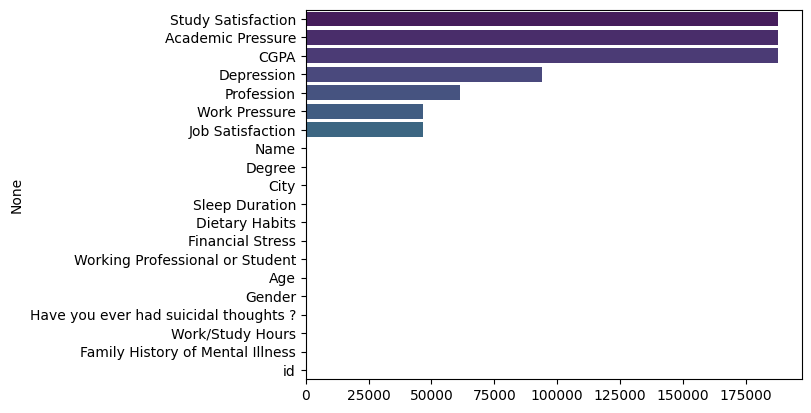

In [1917]:
show_missing_values(data)

<Axes: ylabel='Count'>

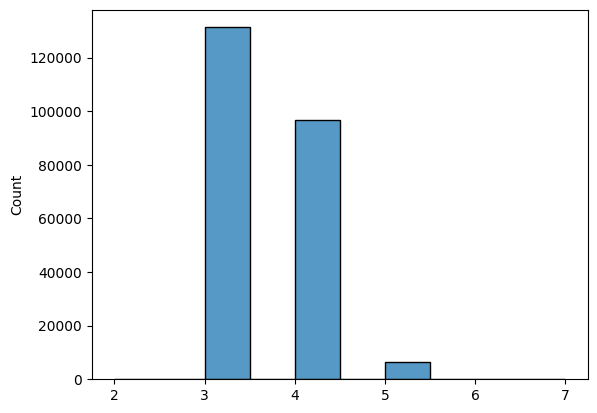

In [1918]:
sns.histplot(data.isnull().sum(axis=1), bins=10)

<Axes: >

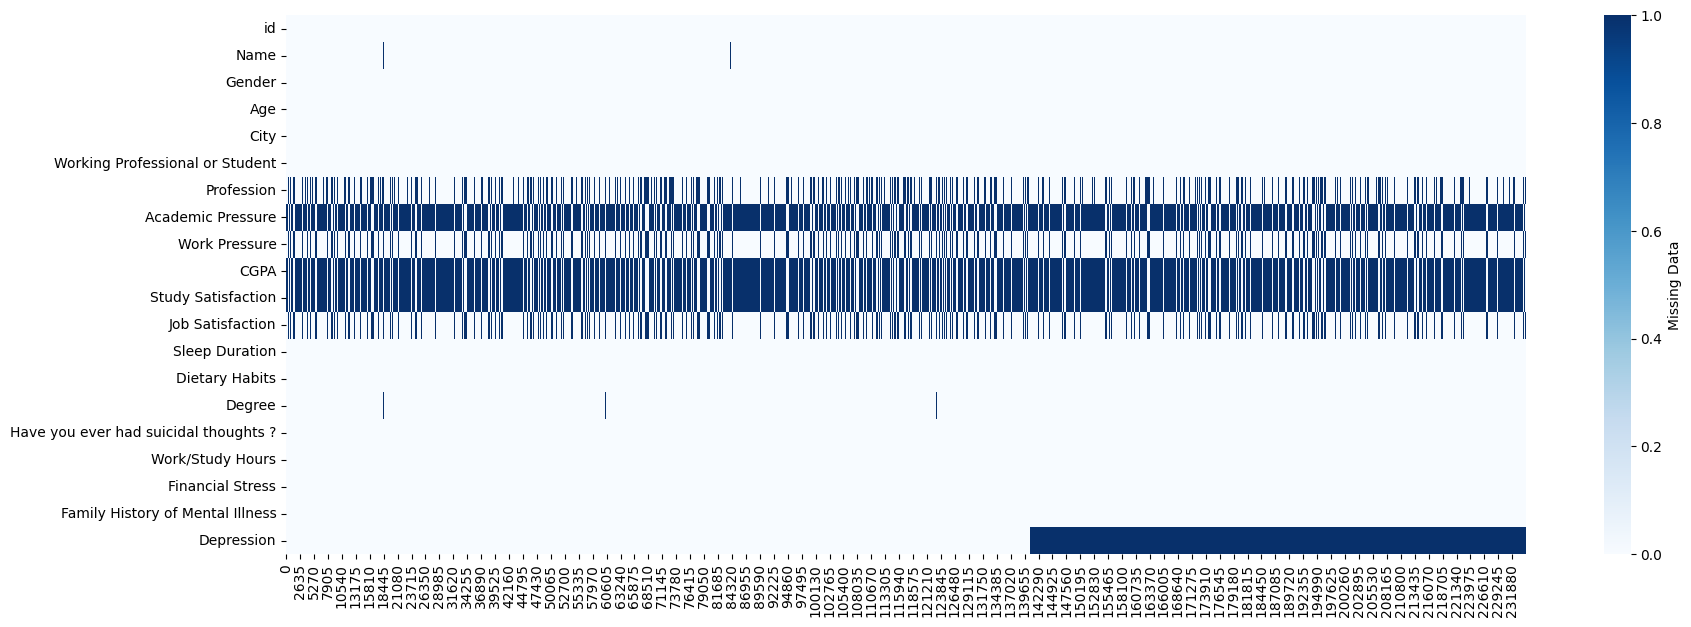

In [1919]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(data.isna().transpose(),cbar_kws={'label': 'Missing Data'},cmap="Blues",ax=ax)

Most missing values have 2 or more if missing value exists within the row. Likely, the columns are correlated with each other in some way.

<Axes: xlabel='Depression', ylabel='count'>

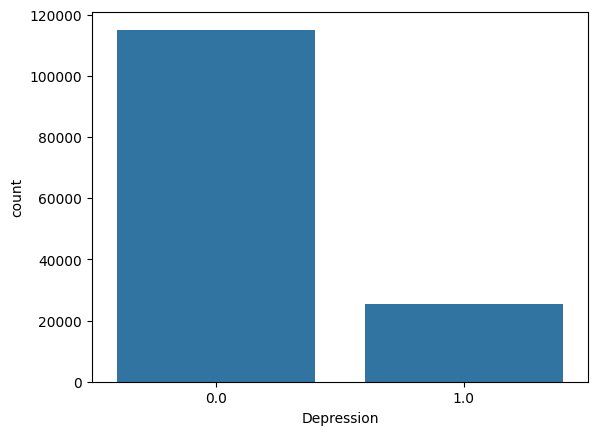

In [1920]:
sns.countplot(data, x="Depression")

<Axes: xlabel='Work/Study Hours', ylabel='count'>

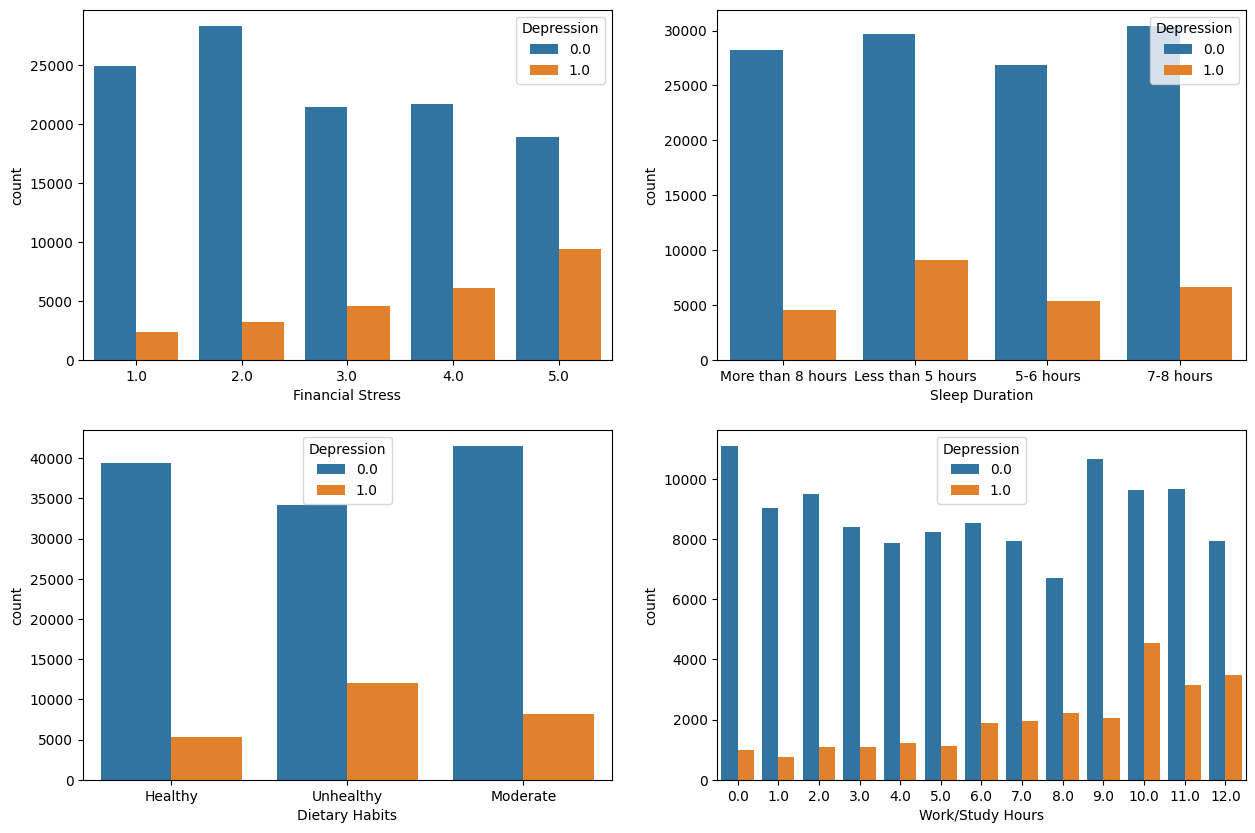

In [1921]:
fig, axes=plt.subplots(ncols=2,nrows=2,figsize=(15,10))

sns.countplot(data,x="Financial Stress",hue="Depression",ax=axes[0][0])
sns.countplot(data,x="Sleep Duration",hue="Depression",ax=axes[0][1])
sns.countplot(data,x="Dietary Habits",hue="Depression",ax=axes[1][0])
sns.countplot(data,x="Work/Study Hours",hue="Depression",ax=axes[1][1])

In [1922]:
data['Financial Stress'] = data['Financial Stress'].transform(lambda x: x.fillna(x.mode()[0])).astype('category')
data['Sleep Duration'] = data['Sleep Duration'].transform(lambda x: x.fillna(x.mode()[0]))
data['Dietary Habits'] = data['Dietary Habits'].transform(lambda x: x.fillna(x.mode()[0]))
data['Degree'] = data.groupby(by=["Working Professional or Student"])['Degree'].transform(lambda x: x.fillna(x.mode()[0]))
data['City'] = data['City'].transform(lambda x: x.fillna(x.mode()[0]))

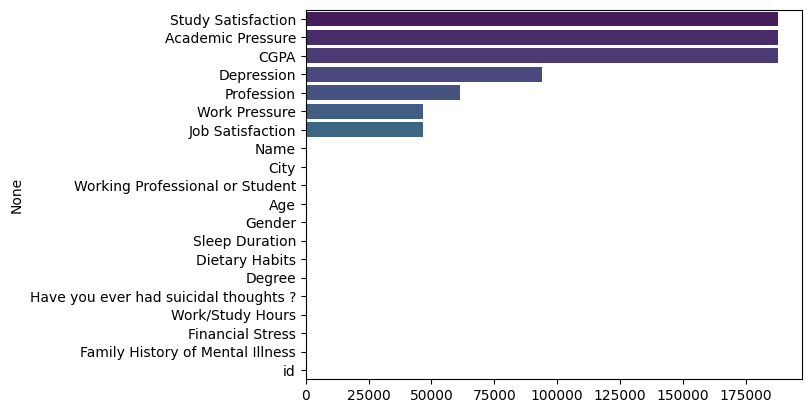

In [1923]:
show_missing_values(data)

In [1924]:
data["Name"] = data["Name"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Job Satisfaction"] = data["Job Satisfaction"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Work Pressure"] = data["Work Pressure"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Profession"] = data["Profession"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')

<Axes: xlabel='Work Pressure', ylabel='count'>

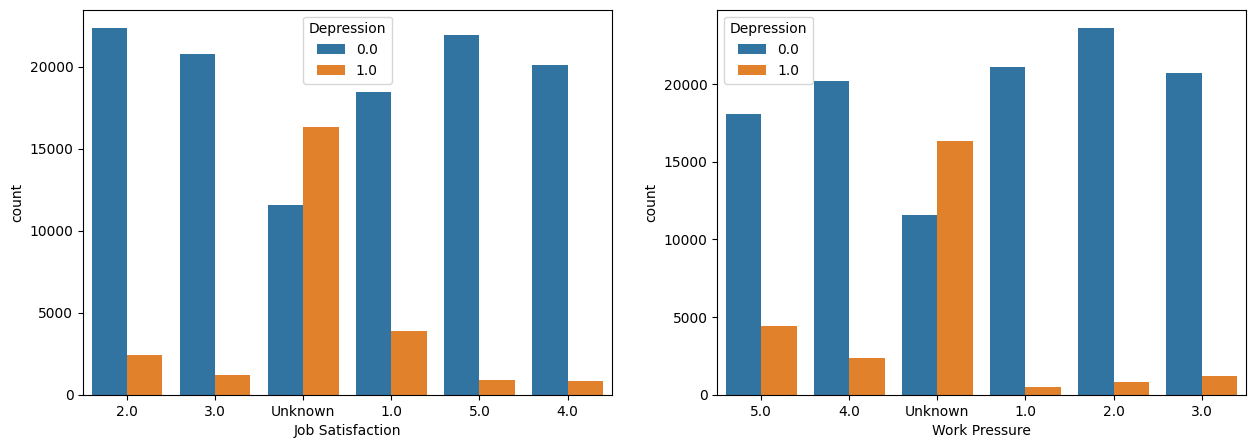

In [1925]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.countplot(data,x="Job Satisfaction",hue="Depression",ax=axes[0])
sns.countplot(data,x="Work Pressure",hue="Depression",ax=axes[1])

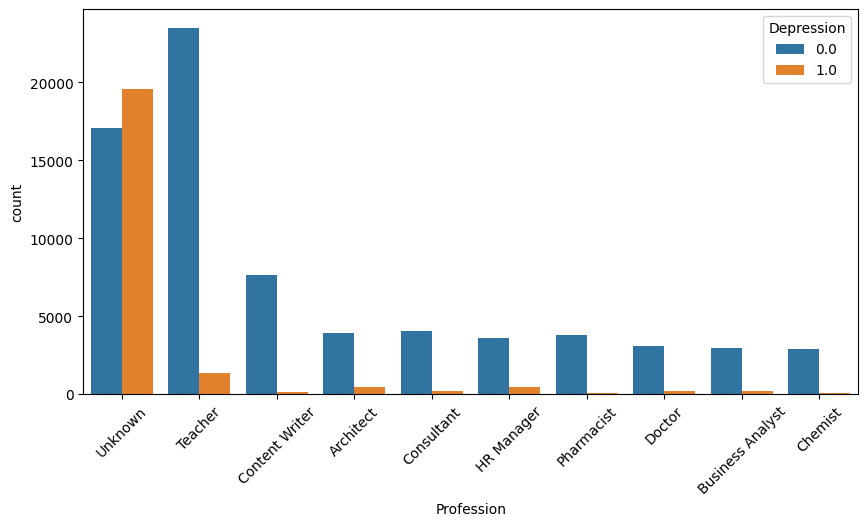

In [1926]:
fig, axs = plt.subplots(ncols=1, nrows=1,figsize=(10,5))
sns.countplot(data,x="Profession",hue="Depression",order=data["Profession"].value_counts().iloc[:10].index,ax=axs)
axs.tick_params(axis='x', rotation=45)

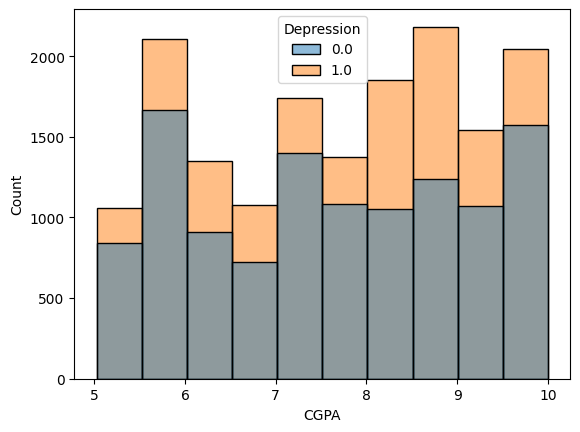

In [1927]:
cgpa_bins = 10
sns.histplot(data,x="CGPA",hue="Depression",bins=cgpa_bins)
data["CGPA"] = pd.cut(data["CGPA"],bins=cgpa_bins).astype('object')

In [1928]:
data["CGPA"] = data["CGPA"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Academic Pressure"] = data["Academic Pressure"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')
data["Study Satisfaction"] = data["Study Satisfaction"].transform(lambda x: x.fillna("Unknown")).astype('str').astype('object')

<Axes: xlabel='Study Satisfaction', ylabel='count'>

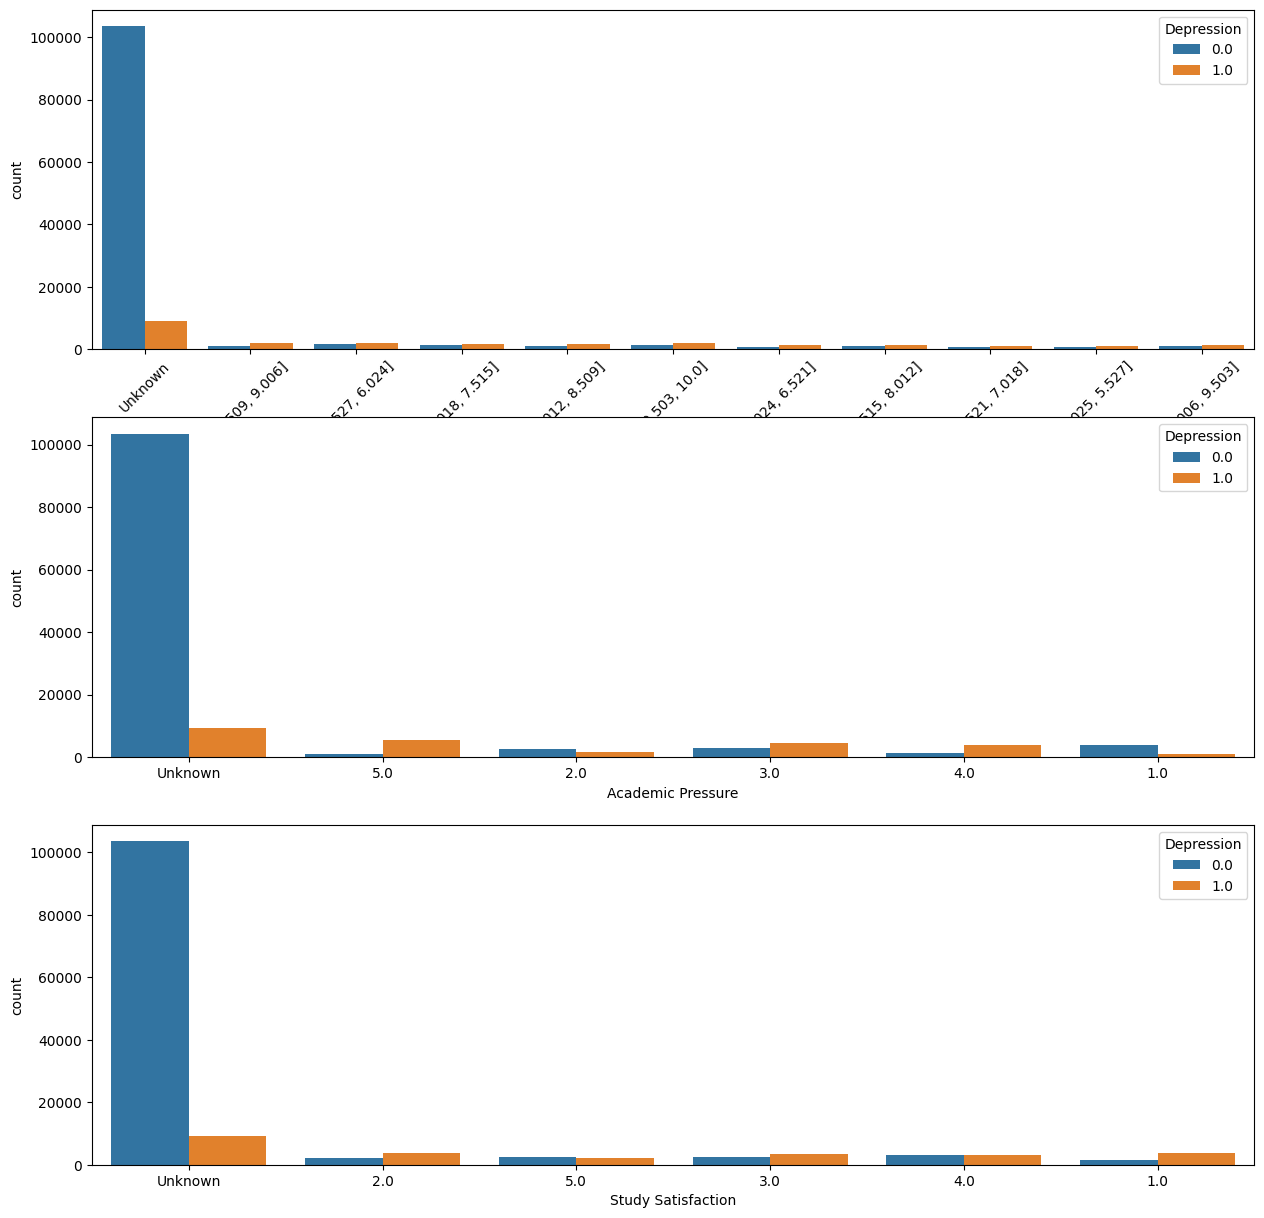

In [1929]:
fig, axs = plt.subplots(ncols=1, nrows=3,figsize=(15,15))
sns.countplot(data,x="CGPA",hue="Depression",ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
sns.countplot(data,x="Academic Pressure",hue="Depression",ax=axs[1])
sns.countplot(data,x="Study Satisfaction",hue="Depression",ax=axs[2])

(0.0, 10000.0)

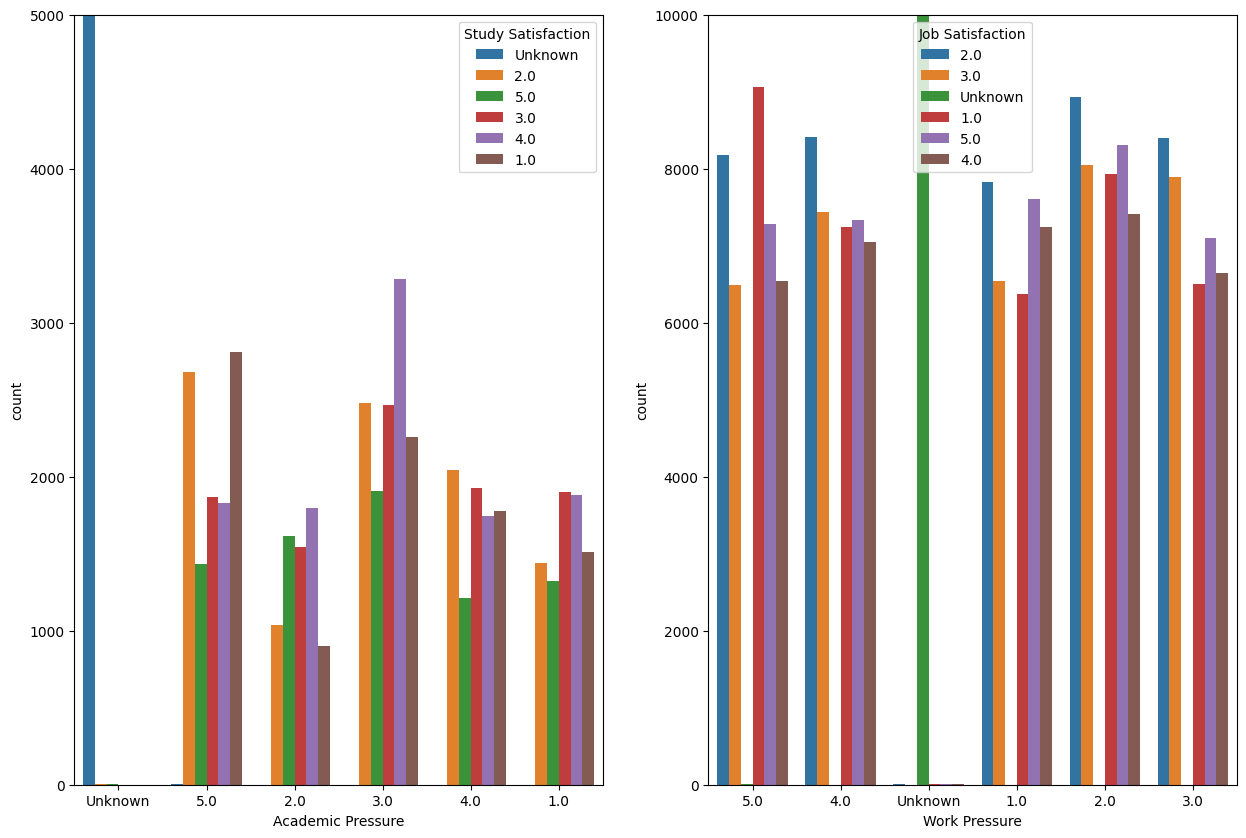

In [1930]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

sns.countplot(data,x="Academic Pressure",hue="Study Satisfaction",ax=axs[0])
sns.countplot(data,x="Work Pressure",hue="Job Satisfaction",ax=axs[1])

axs[0].set_ylim(0, 5000)
axs[1].set_ylim(0, 10000)

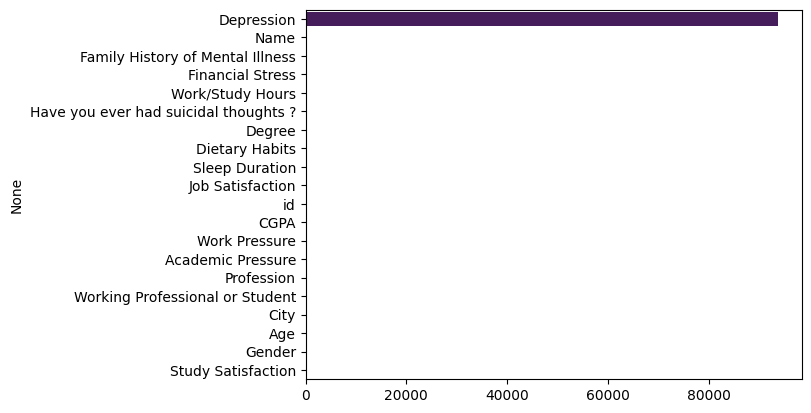

In [1931]:
show_missing_values(data)

In [1932]:
data_corr = pd.DataFrame(data)
oe = LabelEncoder()

for col in data_corr.select_dtypes(include='object').columns:
    if col == "Depression":
        continue
    data_corr[col] = oe.fit_transform(data_corr[col])

In [1933]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,Unknown,5.0,Unknown,Unknown,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0.0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,Unknown,4.0,Unknown,Unknown,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1.0
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,Unknown,5.0,Unknown,"(8.509, 9.006]",2.0,Unknown,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1.0
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,Unknown,5.0,Unknown,Unknown,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1.0
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,Unknown,1.0,Unknown,Unknown,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0.0


In [1934]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     234500 non-null  int64   
 1   Name                                   234500 non-null  int32   
 2   Gender                                 234500 non-null  int32   
 3   Age                                    234500 non-null  float64 
 4   City                                   234500 non-null  int32   
 5   Working Professional or Student        234500 non-null  int32   
 6   Profession                             234500 non-null  int32   
 7   Academic Pressure                      234500 non-null  int32   
 8   Work Pressure                          234500 non-null  int32   
 9   CGPA                                   234500 non-null  int32   
 10  Study Satisfaction                     23450

<Axes: >

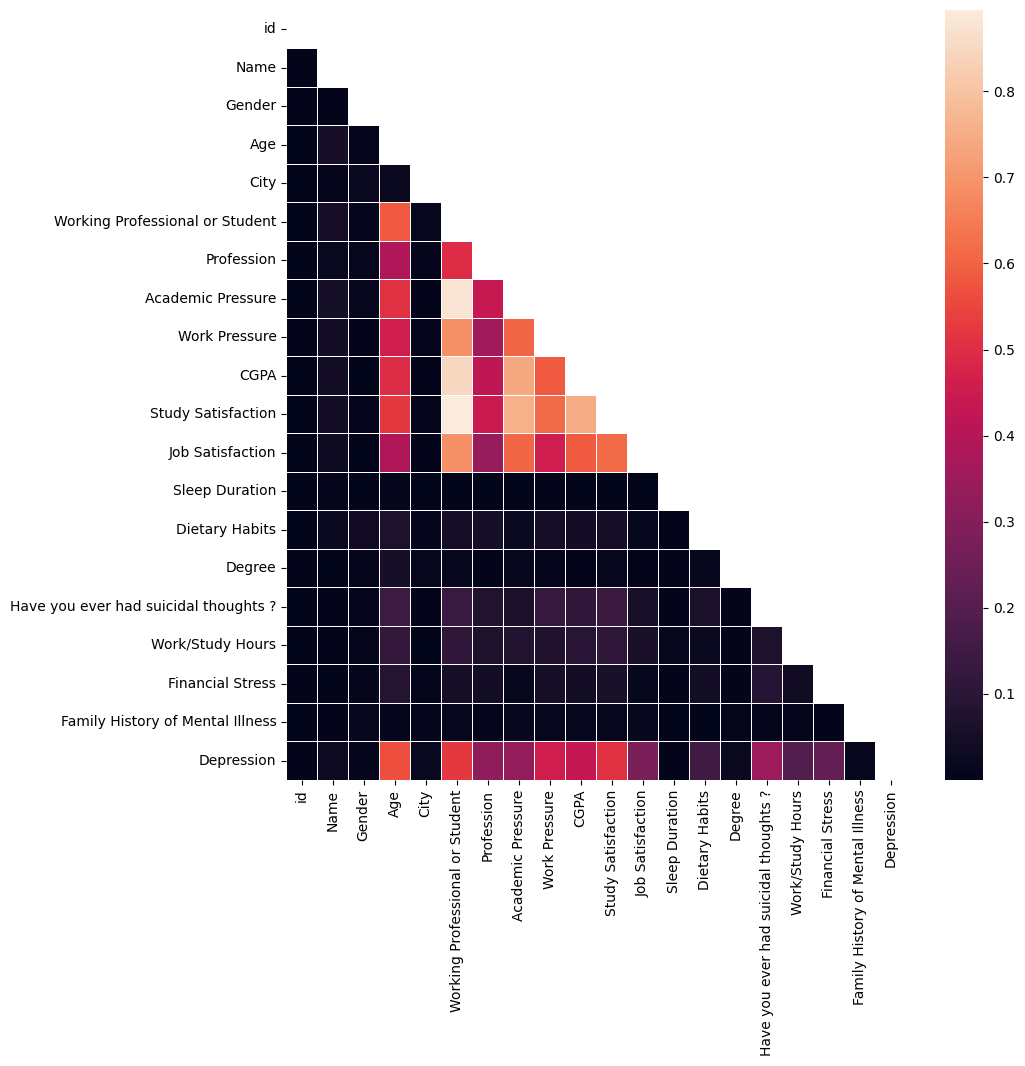

In [1935]:
f, ax = plt.subplots(figsize=(10, 10))

corr = data_corr.corr().abs()
matrix_mask = np.triu(np.ones_like(corr)) # only show the upper triangular for the correlation matrix
sns.heatmap(corr, linewidths=.5, mask=matrix_mask)

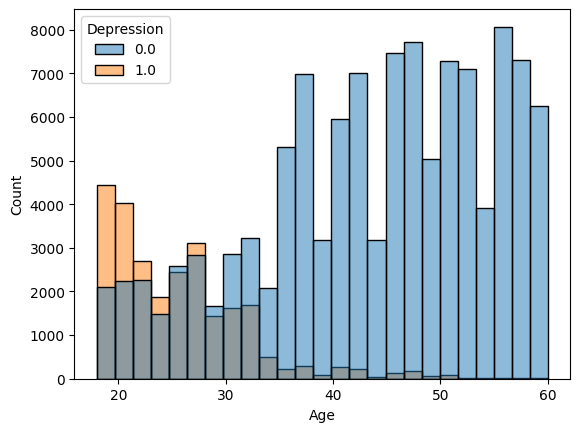

In [1936]:
age_bins = 25
sns.histplot(data,x="Age",bins=age_bins,hue="Depression")
data["Age"] = pd.cut(data["Age"],bins=age_bins)

In [1937]:
data['Name_CE'] = data['Name'].map(data['Name'].value_counts()) # count encode name. most likely useless since depression isn't likely tied to name
data = data.drop("Name",axis=1)

In [1938]:
data['City_CE'] = data['City'].map(data['City'].value_counts()) # count encode city

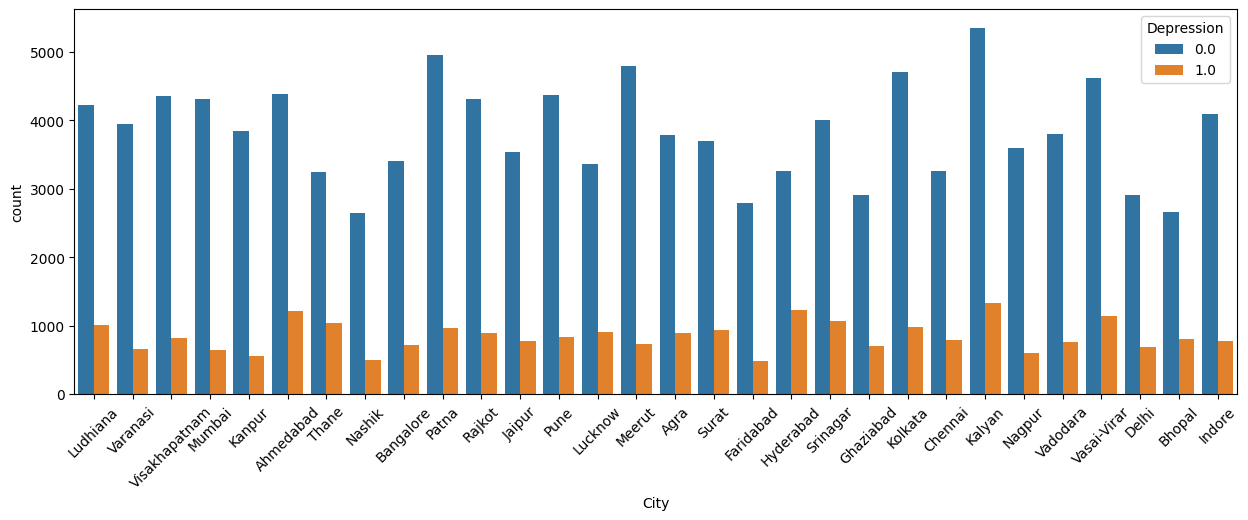

In [1939]:
fig,axes=plt.subplots(figsize=(15,5))
sns.countplot(data,x="City",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

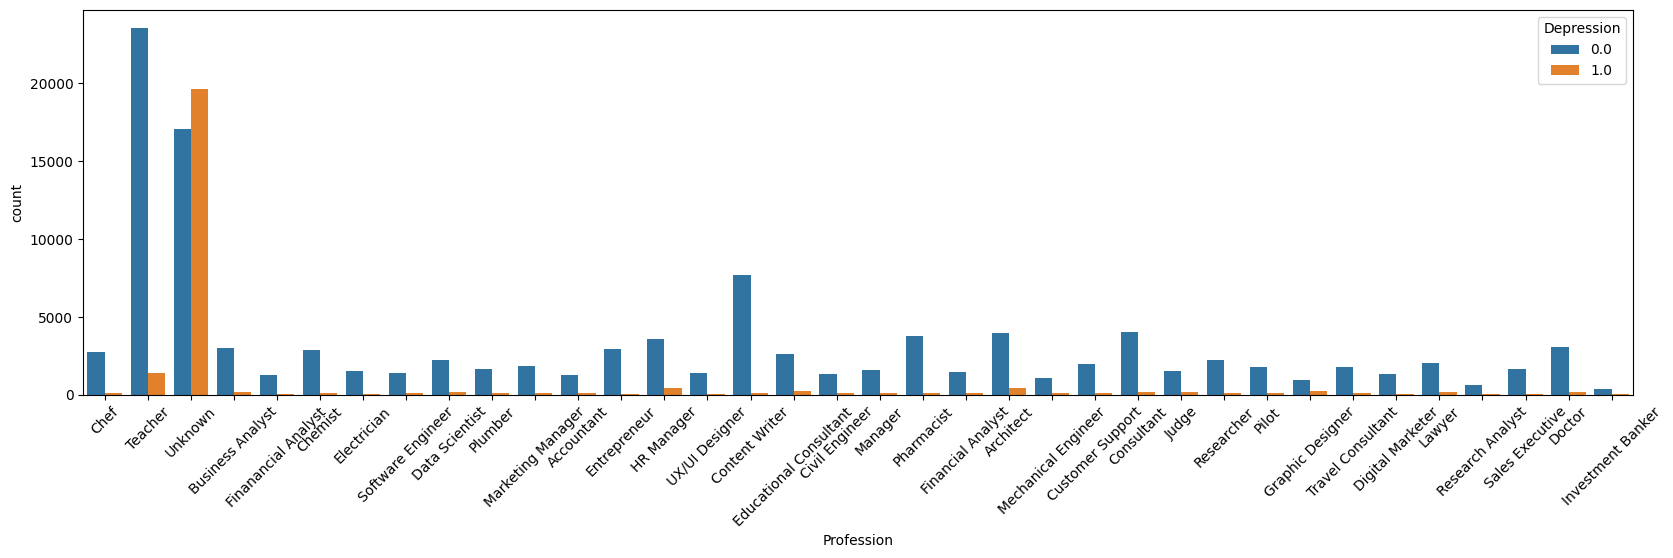

In [1940]:
fig,axes=plt.subplots(figsize=(20,5))
sns.countplot(data,x="Profession",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

In [1941]:
data['Profession'] = data['Profession'].replace('Finanancial Analyst', 'Financial Analyst') # fix more artifacts

data["Profession_Analyst"] = data['Profession'].isin(["Business Analyst", "Financial Analyst", "Research Analyst"])
data["Engineer"] = data['Profession'].isin(["Software Engineer", "Civil Engineer", "Mechanical Engineer"])
data["Manager"] = data['Profession'].isin(["Marketing Manager", "HR Manager", "Manager"])
data["Designer"] = data['Profession'].isin(["UX/UI Designer", "Graphic Designer"])
data["Consultant"] = data['Profession'].isin(["Educational Consultant", "Consultant", "Travel Consultant"])

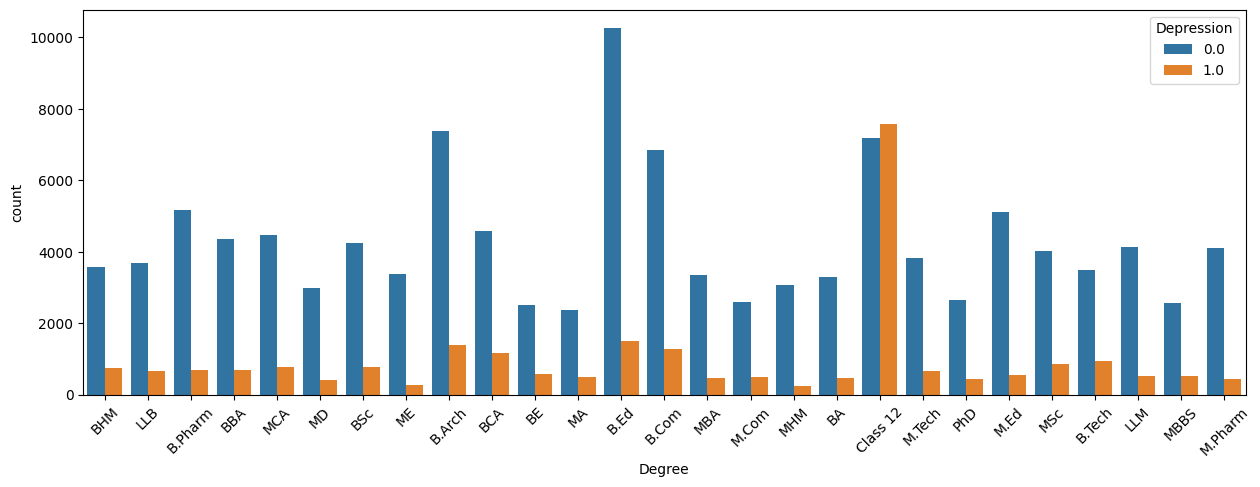

In [1942]:
fig,axes=plt.subplots(figsize=(15,5))
sns.countplot(data,x="Degree",hue="Depression",ax=axes)
axes.tick_params(axis='x', rotation=45)

In [1943]:
data['Degree_Bachelor'] = data['Degree'].isin(["BHM", "LLB", "B.Pharm", "BBA", "BSc", "B.Arch", "BCA", "BE", "B.Ed", "B.Com", "BA", "B.Tech", "MBBS"])
data['Degree_Master'] = data['Degree'].isin(["MCA", "ME", "MA", "MBA", "M.Com", "MHM", "M.Tech", "M.Ed", "MSc", "LLM", "M.Pharm"])
data['Degree_Doctor'] = data['Degree'].isin(["MD"])
data["Degree_HM"] = data['Degree'].isin(["BHM", "MHM"])
data["Degree_LL"] = data['Degree'].isin(["LLB", "LLM"])
data["Degree_Pharm"] = data['Degree'].isin(["B.Pharm", "M.Pharm"])
data["Degree_BA"] = data['Degree'].isin(["BBA", "MBA"])
data["Degree_CA"] = data['Degree'].isin(["BCA", "MCA"])
data["Degree_Medicine"] = data['Degree'].isin(["MD", "MBBS"])
data["Degree_Sc"] = data['Degree'].isin(["BSc", "MSc"])
data["Degree_E"] = data['Degree'].isin(["BE","ME"])
data["Degree_B.Arch"] = data['Degree'].isin(["B.Arch"])
data["Degree_A"] = data['Degree'].isin(["BA","MA"])
data["Degree_Ed"] = data['Degree'].isin(["B.Ed","M.Ed"])
data["Degree_Com"] = data['Degree'].isin(["B.Com","M.Com"])
data["Degree_Class_12"] = data['Degree'].isin(["Class 12"])
data["Degree_Tech"] = data['Degree'].isin(["B.Tech","M.Tech"])

data = data.drop('Degree', axis=1)

In [1944]:
columns = ["Working Professional or Student", "Have you ever had suicidal thoughts ?"]

le = LabelEncoder()

for col in columns:
    data[col] = le.fit_transform(data[col])

In [1945]:
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')

In [1946]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Data columns (total 42 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     234500 non-null  int64   
 1   Gender                                 234500 non-null  category
 2   Age                                    234500 non-null  category
 3   City                                   234500 non-null  category
 4   Working Professional or Student        234500 non-null  int32   
 5   Profession                             234500 non-null  category
 6   Academic Pressure                      234500 non-null  category
 7   Work Pressure                          234500 non-null  category
 8   CGPA                                   234500 non-null  category
 9   Study Satisfaction                     234500 non-null  category
 10  Job Satisfaction                       23450

In [1947]:
data = pd.get_dummies(data, columns=["Age", "Academic Pressure", "Work Pressure", "CGPA", "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "Dietary Habits", "Work/Study Hours", "Financial Stress", "City", "Profession"])
# one hot encode

In [1948]:
for col in data.select_dtypes(include='category').columns:
    data[col] = data[col].cat.codes.astype(bool)

for col in data.select_dtypes(include='int32').columns:
    data[col] = data[col].astype(bool)

# convert rest of boolean category types to boolean type

In [1949]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Columns: 180 entries, id to Profession_Unknown
dtypes: bool(176), float64(1), int64(3)
memory usage: 46.5 MB


In [1950]:
data.columns = data.columns.str.replace(',', '_')
data.columns = data.columns.str.replace('[', '_')
data.columns = data.columns.str.replace(']', '_')
# replace illegal characters with underscore

In [1951]:
train_data = data[data['Depression'].notna()]
test_data = data[data['Depression'].isna()]
test_data = test_data.drop('Depression', axis=1)

test_id = test_data[['id']].copy()
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

In [1952]:
X = train_data.drop('Depression', axis=1)
y = (train_data['Depression'] == True)

In [1953]:
kf = KFold(n_splits=5, shuffle=False)

In [1954]:
xgb_model = XGBClassifier(n_jobs=-1,enable_categorical=False,device="cuda",random_state=1) # use nvidia cuda supported gpu
scores = cross_val_score(xgb_model, X, y, cv=5)
xgb_model.fit(X, y)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.9378962331201137


In [1955]:
y_pred_submission = xgb_model.predict(test_data)

In [1956]:
test_submission = test_id
test_submission['Depression'] = y_pred_submission
test_submission.head()

test_submission.to_csv("submission.csv", index=False)

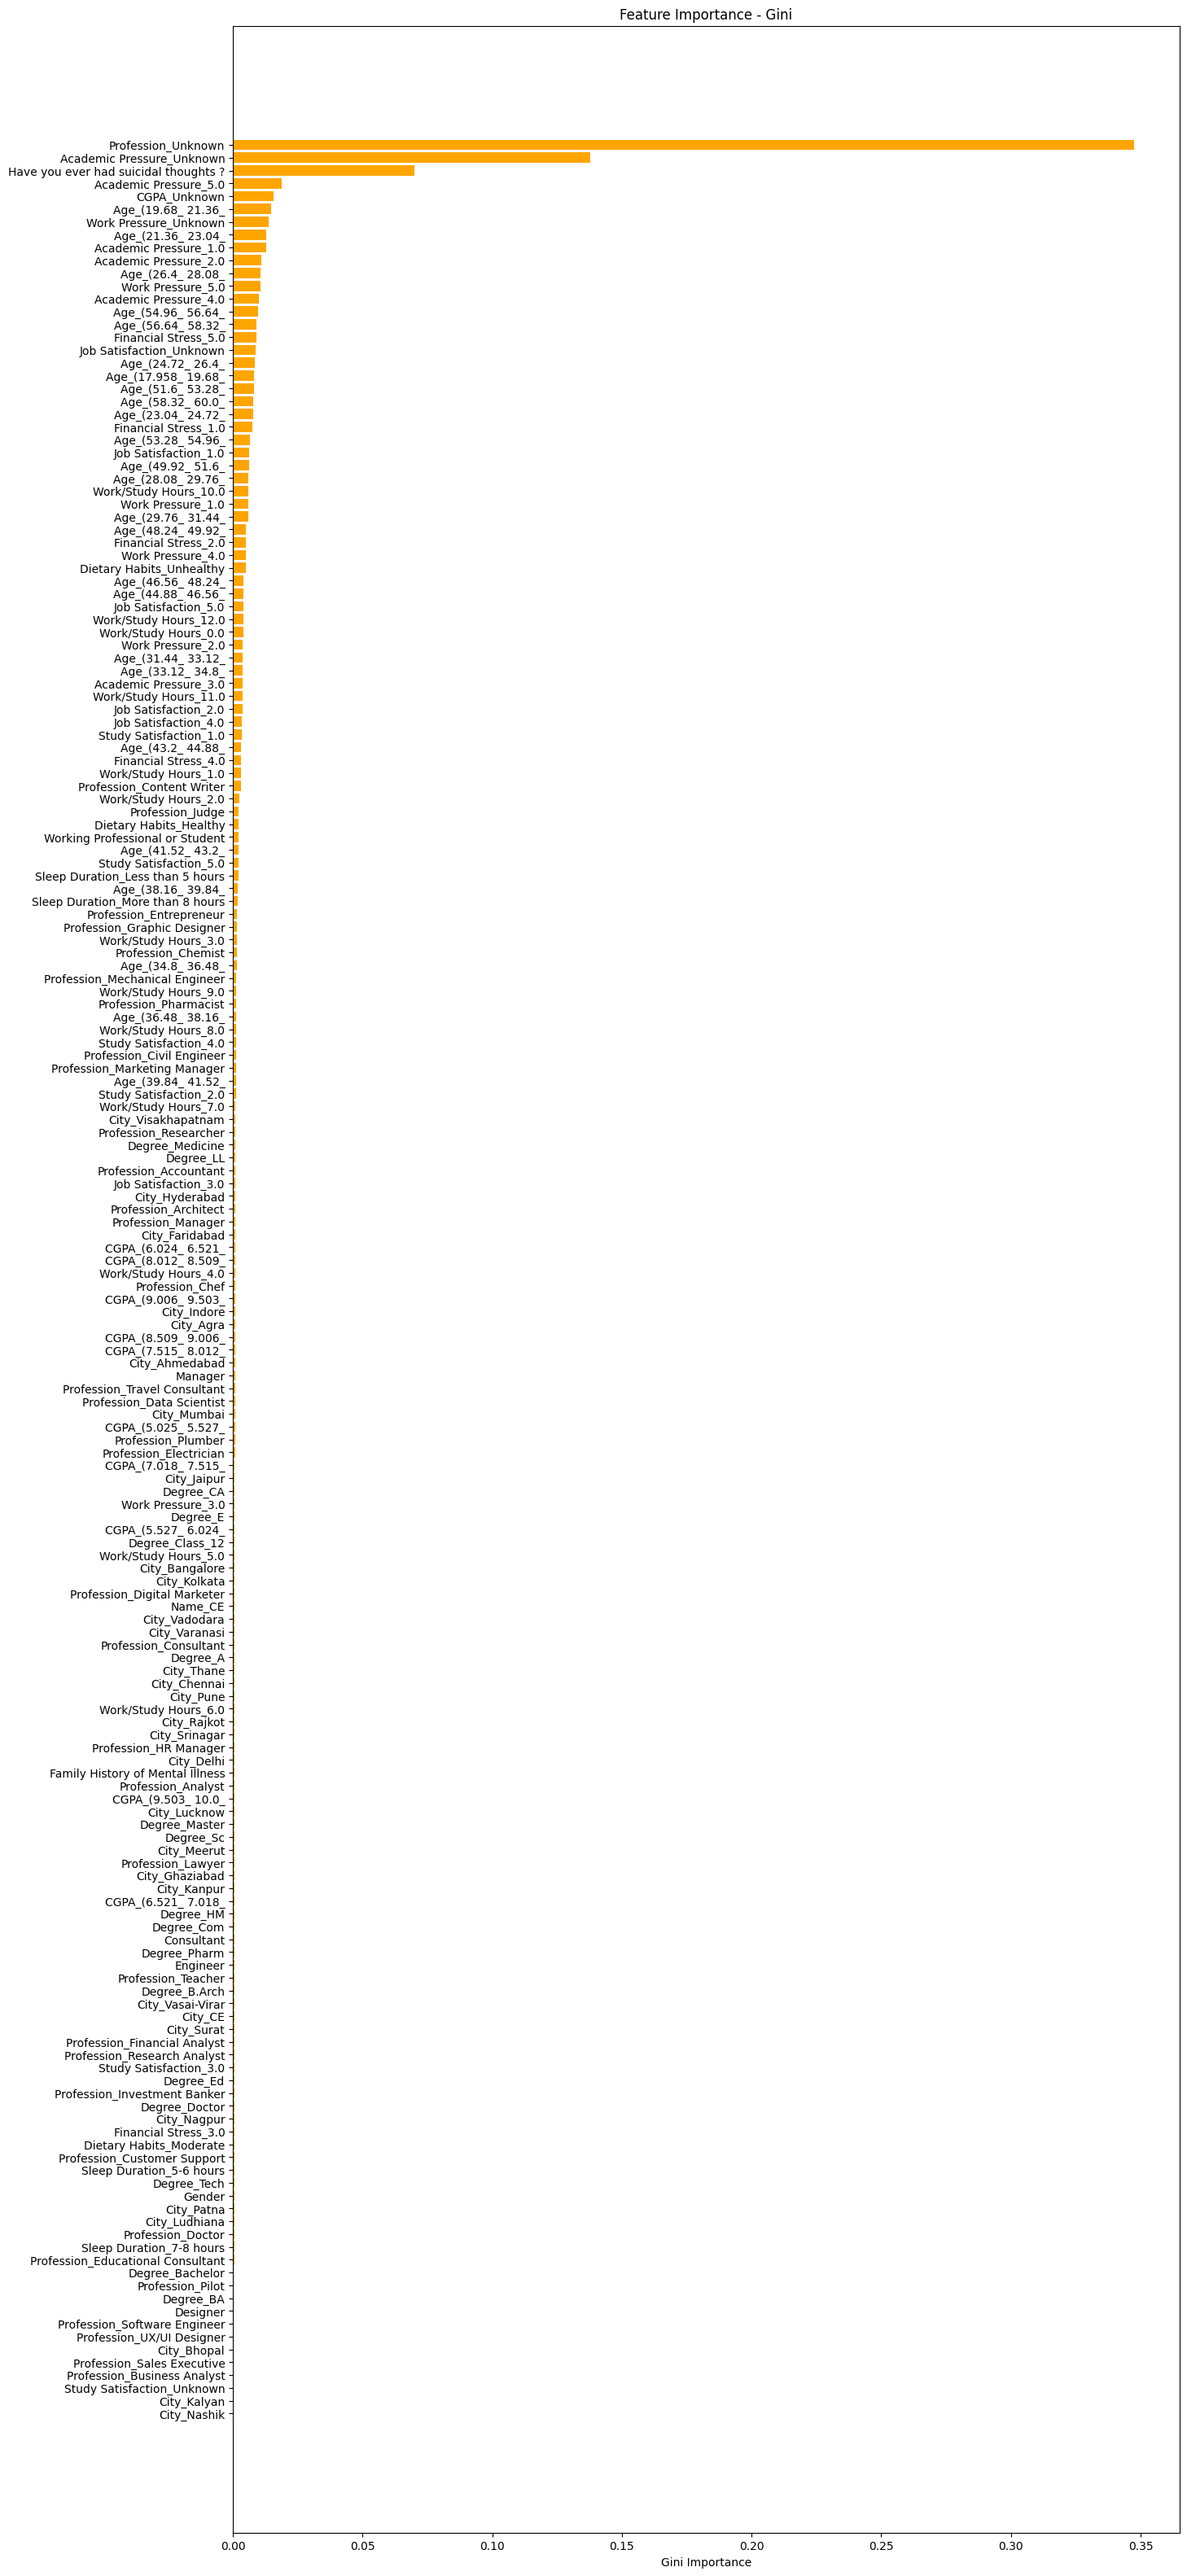

In [1957]:
feature_names = list(test_data.columns)
ft_importances = xgb_model.feature_importances_

sorted_idx = np.argsort(ft_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = ft_importances[sorted_idx]

plt.figure(figsize=(15, 40))
plt.barh(sorted_features, sorted_importances, color='orange')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini')
plt.gca().invert_yaxis()
plt.show()

In [1958]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234500 entries, 0 to 234499
Columns: 180 entries, id to Profession_Unknown
dtypes: bool(176), float64(1), int64(3)
memory usage: 46.5 MB
